In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
from timm import create_model

In [ ]:
DATA_DIR = "/content/drive/MyDrive/TestingbyZMA/paddy-disease-classification/train"
BATCH_SIZE = 32  # Keep batch size reasonable
NUM_EPOCHS = 25  # Reduced further for faster training
DENSENET_SIZE = 256  # Reduced from 384 to 256 for faster training
SWIN_SIZE = 224
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
DROPOUT = 0.3
SEED = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

MODEL_DIR = "/content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/models"
LOG_DIR = "/content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/logs"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

torch.manual_seed(SEED)

Using device: cuda


In [ ]:
train_transforms_densenet = transforms.Compose([
    transforms.Resize((DENSENET_SIZE, DENSENET_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms_densenet = transforms.Compose([
    transforms.Resize((DENSENET_SIZE, DENSENET_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_transforms_swin = transforms.Compose([
    transforms.Resize((SWIN_SIZE, SWIN_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms_swin = transforms.Compose([
    transforms.Resize((SWIN_SIZE, SWIN_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
print("Loading dataset...")
full_dataset = datasets.ImageFolder(DATA_DIR)
NUM_CLASSES = len(full_dataset.classes)

print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))

# Create splits
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")

# Split indices
train_indices, val_indices = random_split(
    list(range(len(full_dataset))),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

Loading dataset...
Classes: ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']
Total images: 10407
Train size: 8325
Validation size: 2082


In [ ]:
class DualTransformDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform1, transform2):
        self.dataset = dataset
        self.indices = indices
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        image, label = self.dataset[original_idx]

        image1 = self.transform1(image)
        image2 = self.transform2(image)

        return image1, image2, label

# Create datasets with dual transforms
train_dataset = DualTransformDataset(
    full_dataset, train_indices,
    train_transforms_densenet, train_transforms_swin
)

val_dataset = DualTransformDataset(
    full_dataset, val_indices,
    val_transforms_densenet, val_transforms_swin
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=4, pin_memory=True,
    persistent_workers=True  # Keep workers alive between epochs
)

val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=4, pin_memory=True,
    persistent_workers=True
)

print("Data loaders created successfully!")

Data loaders created successfully!


In [ ]:
def train_model_fast(model, train_loader, val_loader, criterion, optimizer,
                     scheduler, num_epochs, model_name, mixed_precision=True):

    best_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())

    history = {
        "epoch": [],
        "learning_rate": [],
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": []
    }

    # Use mixed precision for faster training
    scaler = torch.cuda.amp.GradScaler() if mixed_precision and torch.cuda.is_available() else None

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        history["epoch"].append(epoch + 1)
        history["learning_rate"].append(optimizer.param_groups[0]["lr"])

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for batch_idx, (images1, images2, labels) in enumerate(train_loader):
            images1, images2, labels = images1.to(DEVICE), images2.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(images1) if model_name == "densenet121" else model(images2)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images1) if model_name == "densenet121" else model(images2)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * images1.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)

            # Print progress every 50 batches
            if batch_idx % 50 == 0:
                print(f"  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc.item())
        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for images1, images2, labels in val_loader:
                images1, images2, labels = images1.to(DEVICE), images2.to(DEVICE), labels.to(DEVICE)

                outputs = model(images1) if model_name == "densenet121" else model(images2)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images1.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        history["val_loss"].append(epoch_loss)
        history["val_accuracy"].append(epoch_acc.item())
        print(f"Val Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(
                model.state_dict(),
                os.path.join(MODEL_DIR, f"{model_name}_best.pth")
            )
            print(f"  ↳ New best model saved! Acc: {best_acc:.4f}")

        if scheduler:
            scheduler.step()

    print(f"\nBest Validation Accuracy: {best_acc:.4f}")

    # Save CSV log
    df = pd.DataFrame(history)
    csv_path = os.path.join(LOG_DIR, f"{model_name}_training_log.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved CSV log to: {csv_path}")

    model.load_state_dict(best_weights)
    return model, history

In [ ]:
print("\n" + "="*50)
print("TRAINING DENSENET121 (OPTIMIZED)")
print("="*50)

densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
densenet.classifier = nn.Sequential(
    nn.Dropout(DROPOUT),
    nn.Linear(densenet.classifier.in_features, NUM_CLASSES)
)
densenet.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer_densenet = optim.AdamW(densenet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_densenet = optim.lr_scheduler.CosineAnnealingLR(optimizer_densenet, T_max=NUM_EPOCHS)

densenet, densenet_history = train_model_fast(
    densenet, train_loader, val_loader,
    criterion, optimizer_densenet, scheduler_densenet,
    NUM_EPOCHS, "densenet121_fast"
)



TRAINING DENSENET121 (OPTIMIZED)

Epoch 1/25
----------------------------------------


/tmp/ipython-input-1744882882.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if mixed_precision and torch.cuda.is_available() else None
/tmp/ipython-input-1744882882.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 0/261, Loss: 2.3975
  Batch 50/261, Loss: 1.8865
  Batch 100/261, Loss: 1.1479
  Batch 150/261, Loss: 0.8832
  Batch 200/261, Loss: 0.7663
  Batch 250/261, Loss: 0.9372
Train Loss: 1.1924 | Acc: 0.6071
Val Loss: 0.5193 | Acc: 0.8463
  ↳ New best model saved! Acc: 0.8463

Epoch 2/25
----------------------------------------
  Batch 0/261, Loss: 0.7955
  Batch 50/261, Loss: 0.4976
  Batch 100/261, Loss: 0.4672
  Batch 150/261, Loss: 0.3200
  Batch 200/261, Loss: 0.3491
  Batch 250/261, Loss: 0.4277
Train Loss: 0.4653 | Acc: 0.8579
Val Loss: 0.3087 | Acc: 0.9059
  ↳ New best model saved! Acc: 0.9059

Epoch 3/25
----------------------------------------
  Batch 0/261, Loss: 0.2260
  Batch 50/261, Loss: 0.3567
  Batch 100/261, Loss: 0.1790
  Batch 150/261, Loss: 0.0492
  Batch 200/261, Loss: 0.2482
  Batch 250/261, Loss: 0.1818
Train Loss: 0.2581 | Acc: 0.9246
Val Loss: 0.1902 | Acc: 0.9438
  ↳ New best model saved! Acc: 0.9438

Epoch 4/25
----------------------------------------
  Ba

In [ ]:
# ======================
# TRAIN SWIN-TINY (FAST)
# ======================
print("\n" + "="*50)
print("TRAINING SWIN-TINY (OPTIMIZED)")
print("="*50)

swin = create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=True,
    num_classes=NUM_CLASSES
)
swin.to(DEVICE)

optimizer_swin = optim.AdamW(swin.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_swin = optim.lr_scheduler.CosineAnnealingLR(optimizer_swin, T_max=NUM_EPOCHS)

swin, swin_history = train_model_fast(
    swin, train_loader, val_loader,
    criterion, optimizer_swin, scheduler_swin,
    NUM_EPOCHS, "swin_tiny_fast"
)


TRAINING SWIN-TINY (OPTIMIZED)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

/tmp/ipython-input-1744882882.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if mixed_precision and torch.cuda.is_available() else None



Epoch 1/25
----------------------------------------


/tmp/ipython-input-1744882882.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 0/261, Loss: 2.2707
  Batch 50/261, Loss: 1.1192
  Batch 100/261, Loss: 0.8084
  Batch 150/261, Loss: 0.6386
  Batch 200/261, Loss: 0.4122
  Batch 250/261, Loss: 0.3678
Train Loss: 0.8284 | Acc: 0.7212
Val Loss: 0.3979 | Acc: 0.8650
  ↳ New best model saved! Acc: 0.8650

Epoch 2/25
----------------------------------------
  Batch 0/261, Loss: 0.3078
  Batch 50/261, Loss: 0.3588
  Batch 100/261, Loss: 0.3023
  Batch 150/261, Loss: 0.2424
  Batch 200/261, Loss: 0.2943
  Batch 250/261, Loss: 0.2159
Train Loss: 0.3384 | Acc: 0.8885
Val Loss: 0.2262 | Acc: 0.9323
  ↳ New best model saved! Acc: 0.9323

Epoch 3/25
----------------------------------------
  Batch 0/261, Loss: 0.2895
  Batch 50/261, Loss: 0.0914
  Batch 100/261, Loss: 0.1026
  Batch 150/261, Loss: 0.0951
  Batch 200/261, Loss: 0.1295
  Batch 250/261, Loss: 0.1197
Train Loss: 0.1993 | Acc: 0.9385
Val Loss: 0.1886 | Acc: 0.9404
  ↳ New best model saved! Acc: 0.9404

Epoch 4/25
----------------------------------------
  Ba

In [ ]:
# ======================
# SIMPLE ENSEMBLE (NO RETRAINING)
# ======================
print("\n" + "="*50)
print("CREATING SIMPLE ENSEMBLE")
print("="*50)

def evaluate_ensemble(model1, model2, val_loader, device):
    model1.eval()
    model2.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images1, images2, labels in val_loader:
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)

            outputs1 = model1(images1)
            outputs2 = model2(images2)

            # Average predictions
            combined_outputs = (outputs1 + outputs2) / 2
            _, predicted = torch.max(combined_outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Evaluate ensemble
ensemble_accuracy = evaluate_ensemble(densenet, swin, val_loader, DEVICE)
print(f"Ensemble Validation Accuracy: {ensemble_accuracy:.2f}%")


CREATING SIMPLE ENSEMBLE
Ensemble Validation Accuracy: 98.22%



SAVING RESULTS


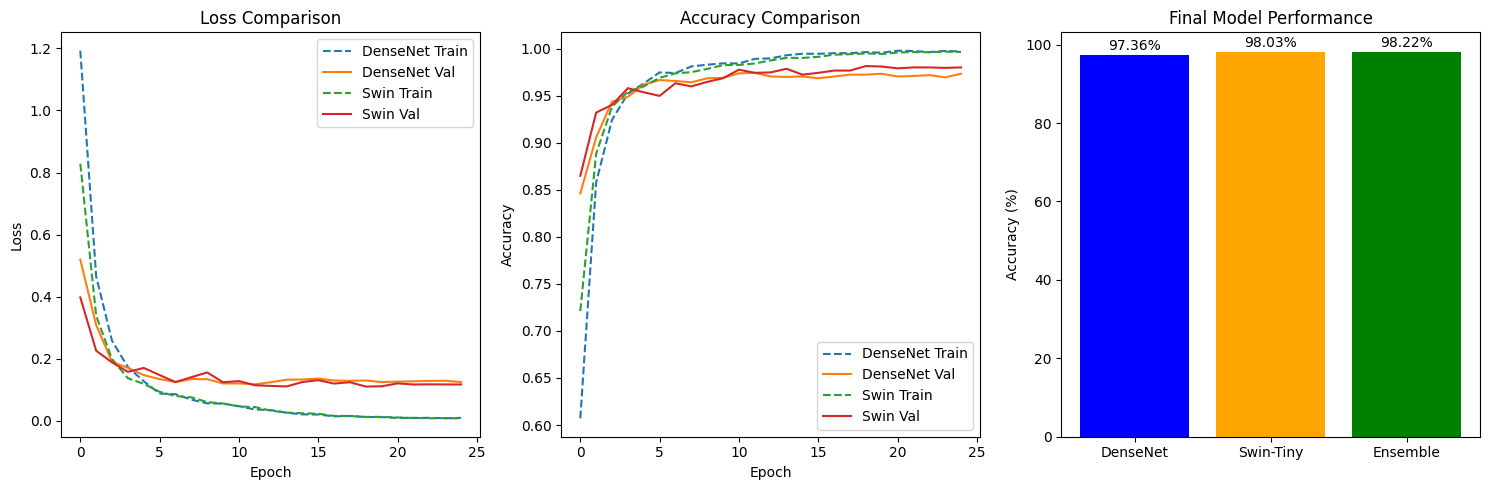


SUMMARY
DenseNet121 Final Val Accuracy: 97.36%
Swin-Tiny Final Val Accuracy: 98.03%
Ensemble Accuracy: 98.22%

Models saved in: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/models
Logs saved in: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/logs

Training completed successfully!


In [ ]:
# ======================
# SAVE RESULTS
# ======================
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

# Plot comparison
plt.figure(figsize=(15, 5))

# Loss comparison
plt.subplot(1, 3, 1)
plt.plot(densenet_history["train_loss"], label="DenseNet Train", linestyle="--")
plt.plot(densenet_history["val_loss"], label="DenseNet Val")
plt.plot(swin_history["train_loss"], label="Swin Train", linestyle="--")
plt.plot(swin_history["val_loss"], label="Swin Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Comparison")

# Accuracy comparison
plt.subplot(1, 3, 2)
plt.plot(densenet_history["train_accuracy"], label="DenseNet Train", linestyle="--")
plt.plot(densenet_history["val_accuracy"], label="DenseNet Val")
plt.plot(swin_history["train_accuracy"], label="Swin Train", linestyle="--")
plt.plot(swin_history["val_accuracy"], label="Swin Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Comparison")

# Final performance
plt.subplot(1, 3, 3)
models_names = ["DenseNet", "Swin-Tiny", "Ensemble"]
accuracies = [
    densenet_history["val_accuracy"][-1] * 100,
    swin_history["val_accuracy"][-1] * 100,
    ensemble_accuracy
]
colors = ['blue', 'orange', 'green']
bars = plt.bar(models_names, accuracies, color=colors)
plt.ylabel("Accuracy (%)")
plt.title("Final Model Performance")

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{acc:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(LOG_DIR, "model_comparison.png"), dpi=150)
plt.show()

# Save summary
results = {
    "densenet121_best_val_acc": densenet_history["val_accuracy"][-1],
    "swin_tiny_best_val_acc": swin_history["val_accuracy"][-1],
    "ensemble_accuracy": ensemble_accuracy / 100,  # Convert to 0-1 scale
    "num_classes": NUM_CLASSES,
    "classes": full_dataset.classes,
    "train_size": train_size,
    "val_size": val_size,
    "parameters": {
        "batch_size": BATCH_SIZE,
        "densenet_size": DENSENET_SIZE,
        "swin_size": SWIN_SIZE,
        "learning_rate": LEARNING_RATE,
        "epochs": NUM_EPOCHS
    }
}

import json
with open(os.path.join(LOG_DIR, "training_summary.json"), "w") as f:
    json.dump(results, f, indent=4)

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"DenseNet121 Final Val Accuracy: {densenet_history['val_accuracy'][-1]*100:.2f}%")
print(f"Swin-Tiny Final Val Accuracy: {swin_history['val_accuracy'][-1]*100:.2f}%")
print(f"Ensemble Accuracy: {ensemble_accuracy:.2f}%")
print(f"\nModels saved in: {MODEL_DIR}")
print(f"Logs saved in: {LOG_DIR}")
print("\nTraining completed successfully!")

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

def train_model_fast(model, train_loader, val_loader, criterion, optimizer,
                     scheduler, num_epochs, model_name, mixed_precision=True):

    best_acc = 0.0
    best_weights = copy.deepcopy(model.state_dict())

    history = {
        "epoch": [],
        "learning_rate": [],
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": []
    }

    # Use mixed precision for faster training
    scaler = torch.amp.GradScaler('cuda') if mixed_precision and torch.cuda.is_available() else None

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        history["epoch"].append(epoch + 1)
        history["learning_rate"].append(optimizer.param_groups[0]["lr"])

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for batch_idx, (images1, images2, labels) in enumerate(train_loader):
            images1, images2, labels = images1.to(DEVICE), images2.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            if scaler:
                with torch.amp.autocast('cuda'):
                    outputs = model(images1) if "densenet" in model_name.lower() else model(images2)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images1) if "densenet" in model_name.lower() else model(images2)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * images1.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)

            # Print progress every 50 batches
            if batch_idx % 50 == 0:
                print(f"  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc.item())
        print(f"Train Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for images1, images2, labels in val_loader:
                images1, images2, labels = images1.to(DEVICE), images2.to(DEVICE), labels.to(DEVICE)

                outputs = model(images1) if "densenet" in model_name.lower() else model(images2)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images1.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        history["val_loss"].append(epoch_loss)
        history["val_accuracy"].append(epoch_acc.item())
        print(f"Val Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(
                model.state_dict(),
                os.path.join(MODEL_DIR, f"{model_name}_best.pth")
            )
            print(f"  ↳ New best model saved! Acc: {best_acc:.4f}")

        if scheduler:
            scheduler.step()

    print(f"\nBest Validation Accuracy: {best_acc:.4f}")

    # Save CSV log
    df = pd.DataFrame(history)
    csv_path = os.path.join(LOG_DIR, f"{model_name}_training_log.csv")
    df.to_csv(csv_path, index=False)
    print(f"Saved CSV log to: {csv_path}")

    model.load_state_dict(best_weights)
    return model, history

In [ ]:
# ======================
# TRAIN SWIN-SMALL (FAST)
# ======================
print("\n" + "="*50)
print("TRAINING SWIN-SMALL (OPTIMIZED)")
print("="*50)

# Create Swin-S model
swin_small = create_model(
    "swin_small_patch4_window7_224",
    pretrained=True,
    num_classes=NUM_CLASSES
)
swin_small.to(DEVICE)

optimizer_swin_small = optim.AdamW(swin_small.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler_swin_small = optim.lr_scheduler.CosineAnnealingLR(optimizer_swin_small, T_max=NUM_EPOCHS)

# Train the model
swin_small, swin_small_history = train_model_fast(
    swin_small, train_loader, val_loader,
    criterion, optimizer_swin_small, scheduler_swin_small,
    NUM_EPOCHS, "swin_small_fast"
)


TRAINING SWIN-SMALL (OPTIMIZED)

Epoch 1/25
----------------------------------------
  Batch 0/261, Loss: 2.2753
  Batch 50/261, Loss: 1.2089
  Batch 100/261, Loss: 1.0034
  Batch 150/261, Loss: 0.7151
  Batch 200/261, Loss: 0.6029
  Batch 250/261, Loss: 0.3018
Train Loss: 0.7309 | Acc: 0.7568
Val Loss: 0.3375 | Acc: 0.8934
  ↳ New best model saved! Acc: 0.8934

Epoch 2/25
----------------------------------------
  Batch 0/261, Loss: 0.2067
  Batch 50/261, Loss: 0.1541
  Batch 100/261, Loss: 0.3578
  Batch 150/261, Loss: 0.2755
  Batch 200/261, Loss: 0.2728
  Batch 250/261, Loss: 0.4839
Train Loss: 0.2661 | Acc: 0.9123
Val Loss: 0.2675 | Acc: 0.9135
  ↳ New best model saved! Acc: 0.9135

Epoch 3/25
----------------------------------------
  Batch 0/261, Loss: 0.1168
  Batch 50/261, Loss: 0.1157
  Batch 100/261, Loss: 0.3997
  Batch 150/261, Loss: 0.0402
  Batch 200/261, Loss: 0.1400
  Batch 250/261, Loss: 0.3865
Train Loss: 0.1608 | Acc: 0.9465
Val Loss: 0.1980 | Acc: 0.9366
  ↳ New b

In [ ]:
# ======================
# ENSEMBLE EVALUATION HELPER FUNCTIONS
# ======================

def evaluate_ensemble(model1, model2, val_loader, device):
    model1.eval()
    model2.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images1, images2, labels in val_loader:
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)

            # Determine which images to use for each model
            if "densenet" in model1._get_name().lower():
                outputs1 = model1(images1)
            else:
                outputs1 = model1(images2)

            if "densenet" in model2._get_name().lower():
                outputs2 = model2(images1)
            else:
                outputs2 = model2(images2)

            # Average predictions
            combined_outputs = (outputs1 + outputs2) / 2
            _, predicted = torch.max(combined_outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [ ]:
# ======================
# CHECK AVAILABLE MODELS AND LOAD IF NEEDED
# ======================
print("\n" + "="*50)
print("CHECKING AVAILABLE TRAINED MODELS")
print("="*50)

import os

# Check which model files exist
model_files = os.listdir(MODEL_DIR)
print("Available model files:")
for f in model_files:
    print(f"  - {f}")

# Load DenseNet121 if needed
densenet_path = os.path.join(MODEL_DIR, "densenet121_fast_best.pth")
if os.path.exists(densenet_path):
    print(f"\nLoading DenseNet121 from: {densenet_path}")
    densenet = models.densenet121(weights=None)
    densenet.classifier = nn.Sequential(
        nn.Dropout(DROPOUT),
        nn.Linear(densenet.classifier.in_features, NUM_CLASSES)
    )
    densenet.load_state_dict(torch.load(densenet_path))
    densenet.to(DEVICE)
    densenet.eval()
    print("✓ DenseNet121 loaded successfully")
else:
    print("✗ DenseNet121 model file not found")

# Load Swin-Tiny if needed
swin_tiny_path = os.path.join(MODEL_DIR, "swin_tiny_fast_best.pth")
if os.path.exists(swin_tiny_path):
    print(f"\nLoading Swin-Tiny from: {swin_tiny_path}")
    swin = create_model(
        "swin_tiny_patch4_window7_224",
        pretrained=False,
        num_classes=NUM_CLASSES
    )
    swin.load_state_dict(torch.load(swin_tiny_path))
    swin.to(DEVICE)
    swin.eval()
    print("✓ Swin-Tiny loaded successfully")
else:
    print("✗ Swin-Tiny model file not found")

# Check if Swin-Small exists
swin_small_path = os.path.join(MODEL_DIR, "swin_small_fast_best.pth")
if os.path.exists(swin_small_path):
    print(f"\nLoading Swin-Small from: {swin_small_path}")
    swin_small = create_model(
        "swin_small_patch4_window7_224",
        pretrained=False,
        num_classes=NUM_CLASSES
    )
    swin_small.load_state_dict(torch.load(swin_small_path))
    swin_small.to(DEVICE)
    swin_small.eval()
    print("✓ Swin-Small loaded successfully")
    swin_small_trained = True
else:
    print("✗ Swin-Small model file not found - needs training")
    swin_small_trained = False

# ======================
# TRAIN SWIN-SMALL IF NOT TRAINED
# ======================
if not swin_small_trained:
    print("\n" + "="*50)
    print("TRAINING SWIN-SMALL MODEL")
    print("="*50)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Create Swin-S model
    swin_small = create_model(
        "swin_small_patch4_window7_224",
        pretrained=True,
        num_classes=NUM_CLASSES
    )
    swin_small.to(DEVICE)

    optimizer_swin_small = optim.AdamW(swin_small.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler_swin_small = optim.lr_scheduler.CosineAnnealingLR(optimizer_swin_small, T_max=NUM_EPOCHS)

    # Train the model
    swin_small, swin_small_history = train_model_fast(
        swin_small, train_loader, val_loader,
        criterion, optimizer_swin_small, scheduler_swin_small,
        NUM_EPOCHS, "swin_small_fast"
    )
else:
    # If model was loaded, we need to evaluate it to get accuracy
    print("\n" + "="*50)
    print("EVALUATING LOADED MODELS")
    print("="*50)

    # Define evaluation function
    def evaluate_model(model, dataloader, device, model_type="swin"):
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images1, images2, labels in dataloader:
                images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)

                if model_type == "densenet":
                    outputs = model(images1)
                else:
                    outputs = model(images2)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return 100 * correct / total

    # Evaluate all models
    print("\nEvaluating model accuracies...")
    densenet_acc = evaluate_model(densenet, val_loader, DEVICE, "densenet")
    swin_tiny_acc = evaluate_model(swin, val_loader, DEVICE, "swin")
    swin_small_acc = evaluate_model(swin_small, val_loader, DEVICE, "swin")

    print(f"✓ DenseNet121 Accuracy: {densenet_acc:.2f}%")
    print(f"✓ Swin-Tiny Accuracy: {swin_tiny_acc:.2f}%")
    print(f"✓ Swin-Small Accuracy: {swin_small_acc:.2f}%")

    # Create history-like structures for compatibility
    densenet_history = {"val_accuracy": [densenet_acc / 100]}
    swin_history = {"val_accuracy": [swin_tiny_acc / 100]}
    swin_small_history = {"val_accuracy": [swin_small_acc / 100]}


CHECKING AVAILABLE TRAINED MODELS
Available model files:
  - densenet121_fast_best.pth
  - swin_tiny_fast_best.pth
  - learnable_ensemble.pth
  - deployment_ensemble.pth
  - swin_small_fast_best.pth

Loading DenseNet121 from: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/models/densenet121_fast_best.pth
✓ DenseNet121 loaded successfully

Loading Swin-Tiny from: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/models/swin_tiny_fast_best.pth
✓ Swin-Tiny loaded successfully

Loading Swin-Small from: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/models/swin_small_fast_best.pth
✓ Swin-Small loaded successfully

EVALUATING LOADED MODELS

Evaluating model accuracies...
✓ DenseNet121 Accuracy: 96.64%
✓ Swin-Tiny Accuracy: 98.17%
✓ Swin-Small Accuracy: 97.93%


In [ ]:
# ======================
# ENSEMBLE EVALUATION FUNCTIONS
# ======================

def evaluate_ensemble(model1, model2, val_loader, device):
    model1.eval()
    model2.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images1, images2, labels in val_loader:
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)

            # Determine which images to use for each model
            if "densenet" in model1._get_name().lower():
                outputs1 = model1(images1)
            else:
                outputs1 = model1(images2)

            if "densenet" in model2._get_name().lower():
                outputs2 = model2(images1)
            else:
                outputs2 = model2(images2)

            # Average predictions
            combined_outputs = (outputs1 + outputs2) / 2
            _, predicted = torch.max(combined_outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [ ]:
# ======================
# COMPARE ENSEMBLES
# ======================
print("\n" + "="*50)
print("COMPARING ENSEMBLE PERFORMANCE")
print("="*50)

print("\nIndividual Model Performances:")
print("-" * 40)

# Get accuracies from history or evaluation
if 'densenet_history' in locals():
    densenet_acc = densenet_history['val_accuracy'][-1] * 100
    swin_tiny_acc = swin_history['val_accuracy'][-1] * 100
    swin_small_acc = swin_small_history['val_accuracy'][-1] * 100
else:
    # Re-evaluate if needed
    densenet_acc = evaluate_model(densenet, val_loader, DEVICE, "densenet")
    swin_tiny_acc = evaluate_model(swin, val_loader, DEVICE, "swin")
    swin_small_acc = evaluate_model(swin_small, val_loader, DEVICE, "swin")

print(f"DenseNet121 Final Val Accuracy: {densenet_acc:.2f}%")
print(f"Swin-Tiny Final Val Accuracy: {swin_tiny_acc:.2f}%")
print(f"Swin-Small Final Val Accuracy: {swin_small_acc:.2f}%")

print("\nEnsemble Comparisons:")
print("-" * 40)

# Ensemble 1: DenseNet121 + Swin-Tiny
ensemble_dense_swin_tiny = evaluate_ensemble(densenet, swin, val_loader, DEVICE)
print(f"1. Ensemble (DenseNet121 + Swin-Tiny): {ensemble_dense_swin_tiny:.2f}%")
print(f"   Improvement over best single model: {ensemble_dense_swin_tiny - max(densenet_acc, swin_tiny_acc):+.2f}%")


COMPARING ENSEMBLE PERFORMANCE

Individual Model Performances:
----------------------------------------
DenseNet121 Final Val Accuracy: 96.64%
Swin-Tiny Final Val Accuracy: 98.17%
Swin-Small Final Val Accuracy: 97.93%

Ensemble Comparisons:
----------------------------------------
1. Ensemble (DenseNet121 + Swin-Tiny): 98.22%
   Improvement over best single model: +0.05%


In [ ]:
# Ensemble 2: DenseNet121 + Swin-Small
ensemble_dense_swin_small = evaluate_ensemble(densenet, swin_small, val_loader, DEVICE)
print(f"\n2. Ensemble (DenseNet121 + Swin-Small): {ensemble_dense_swin_small:.2f}%")
print(f"   Improvement over best single model: {ensemble_dense_swin_small - max(densenet_acc, swin_small_acc):+.2f}%")

# Compare the two ensembles
print("\n" + "="*50)
print("DIRECT COMPARISON")
print("="*50)
if ensemble_dense_swin_small > ensemble_dense_swin_tiny:
    improvement = ensemble_dense_swin_small - ensemble_dense_swin_tiny
    print(f"✓ Ensemble (DenseNet121 + Swin-Small) performs BETTER by {improvement:.2f}%")
    print(f"  Accuracy: {ensemble_dense_swin_small:.2f}% vs {ensemble_dense_swin_tiny:.2f}%")
    print(f"  Relative improvement: {(improvement/ensemble_dense_swin_tiny)*100:.2f}%")
else:
    improvement = ensemble_dense_swin_tiny - ensemble_dense_swin_small
    print(f"✓ Ensemble (DenseNet121 + Swin-Tiny) performs BETTER by {improvement:.2f}%")
    print(f"  Accuracy: {ensemble_dense_swin_tiny:.2f}% vs {ensemble_dense_swin_small:.2f}%")
    print(f"  Relative improvement: {(improvement/ensemble_dense_swin_small)*100:.2f}%")


2. Ensemble (DenseNet121 + Swin-Small): 98.08%
   Improvement over best single model: +0.14%

DIRECT COMPARISON
✓ Ensemble (DenseNet121 + Swin-Tiny) performs BETTER by 0.14%
  Accuracy: 98.22% vs 98.08%
  Relative improvement: 0.15%


In [ ]:
# ======================
# CONTINUE DETECTION WITH VISUALIZATION AND ANALYSIS
# ======================
print("\n" + "="*50)
print("CONTINUING DETECTION: VISUALIZATION AND ANALYSIS")
print("="*50)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random

# Create detection results directory
DETECTION_DIR = os.path.join(LOG_DIR, "detection_results")
os.makedirs(DETECTION_DIR, exist_ok=True)

# ======================
# 1. LOAD BEST ENSEMBLE MODEL
# ======================

def load_best_ensemble():
    """Load the best performing ensemble based on previous results"""
    # Determine which ensemble is better
    if ensemble_dense_swin_small > ensemble_dense_swin_tiny:
        print("✓ Loading Ensemble (DenseNet121 + Swin-Small) - Best performer")
        best_name = "Ensemble_DenseNet_SwinSmall"
        best_accuracy = ensemble_dense_swin_small
    else:
        print("✓ Loading Ensemble (DenseNet121 + Swin-Tiny) - Best performer")
        best_name = "Ensemble_DenseNet_SwinTiny"
        best_accuracy = ensemble_dense_swin_tiny

    return best_name, best_accuracy

best_ensemble_name, best_ensemble_acc = load_best_ensemble()
print(f"Best Ensemble: {best_ensemble_name}")
print(f"Accuracy: {best_ensemble_acc:.2f}%")


CONTINUING DETECTION: VISUALIZATION AND ANALYSIS
✓ Loading Ensemble (DenseNet121 + Swin-Tiny) - Best performer
Best Ensemble: Ensemble_DenseNet_SwinTiny
Accuracy: 98.22%


In [ ]:
# ======================
# 2. CREATE COMPREHENSIVE DETECTION FUNCTION
# ======================

def comprehensive_detection(model1, model2, dataloader, device, model1_type="densenet", model2_type="swin"):
    """
    Perform comprehensive detection with detailed outputs
    """
    model1.eval()
    model2.eval()

    all_predictions = []
    all_true_labels = []
    all_confidences = []
    all_class_probabilities = []
    all_image_indices = []

    # For storing per-image details
    detection_details = []

    with torch.no_grad():
        for batch_idx, (images1, images2, labels) in enumerate(dataloader):
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)

            # Get predictions from both models
            if model1_type == "densenet":
                outputs1 = model1(images1)
            else:
                outputs1 = model1(images2)

            if model2_type == "densenet":
                outputs2 = model2(images1)
            else:
                outputs2 = model2(images2)

            # Ensemble predictions (average)
            ensemble_outputs = (outputs1 + outputs2) / 2
            probabilities = torch.nn.functional.softmax(ensemble_outputs, dim=1)
            confidences, predictions = torch.max(probabilities, 1)

            # Get individual model predictions for analysis
            probs1 = torch.nn.functional.softmax(outputs1, dim=1)
            conf1, pred1 = torch.max(probs1, 1)
            probs2 = torch.nn.functional.softmax(outputs2, dim=1)
            conf2, pred2 = torch.max(probs2, 1)

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())
            all_class_probabilities.extend(probabilities.cpu().numpy())

            # Store detailed information per image
            for i in range(len(labels)):
                idx = batch_idx * dataloader.batch_size + i
                all_image_indices.append(idx)

                detail = {
                    "image_index": idx,
                    "true_label": int(labels[i].cpu().numpy()),
                    "true_class": full_dataset.classes[int(labels[i].cpu().numpy())],
                    "ensemble_prediction": int(predictions[i].cpu().numpy()),
                    "ensemble_predicted_class": full_dataset.classes[int(predictions[i].cpu().numpy())],
                    "ensemble_confidence": float(confidences[i].cpu().numpy()),
                    "ensemble_class_probabilities": probabilities[i].cpu().numpy().tolist(),
                    "model1_prediction": int(pred1[i].cpu().numpy()),
                    "model1_confidence": float(conf1[i].cpu().numpy()),
                    "model2_prediction": int(pred2[i].cpu().numpy()),
                    "model2_confidence": float(conf2[i].cpu().numpy()),
                    "is_correct": bool(predictions[i] == labels[i]),
                    "model1_correct": bool(pred1[i] == labels[i]),
                    "model2_correct": bool(pred2[i] == labels[i]),
                    "agreement": bool(pred1[i] == pred2[i]),
                    "disagreement_resolved": bool(predictions[i] == labels[i]) if pred1[i] != pred2[i] else None
                }
                detection_details.append(detail)

    return {
        "predictions": np.array(all_predictions),
        "true_labels": np.array(all_true_labels),
        "confidences": np.array(all_confidences),
        "class_probabilities": np.array(all_class_probabilities),
        "image_indices": np.array(all_image_indices),
        "details": detection_details
    }

In [ ]:
# ======================
# 3. RUN COMPREHENSIVE DETECTION
# ======================

print("\n" + "="*50)
print("RUNNING COMPREHENSIVE DETECTION")
print("="*50)

# Run detection based on best ensemble
if "SwinSmall" in best_ensemble_name:
    detection_results = comprehensive_detection(densenet, swin_small, val_loader, DEVICE, "densenet", "swin")
else:
    detection_results = comprehensive_detection(densenet, swin, val_loader, DEVICE, "densenet", "swin")

print(f"✓ Detection completed on {len(detection_results['predictions'])} images")


RUNNING COMPREHENSIVE DETECTION
✓ Detection completed on 2082 images


In [ ]:
# ======================
# 4. CREATE DETECTION METRICS
# ======================

def calculate_detection_metrics(detection_results, class_names):
    """Calculate comprehensive detection metrics"""

    predictions = detection_results["predictions"]
    true_labels = detection_results["true_labels"]
    confidences = detection_results["confidences"]
    details = detection_results["details"]

    # Basic metrics
    accuracy = np.mean(predictions == true_labels) * 100

    # Confidence analysis
    correct_confidences = [d["ensemble_confidence"] for d in details if d["is_correct"]]
    incorrect_confidences = [d["ensemble_confidence"] for d in details if not d["is_correct"]]

    avg_confidence_correct = np.mean(correct_confidences) * 100 if correct_confidences else 0
    avg_confidence_incorrect = np.mean(incorrect_confidences) * 100 if incorrect_confidences else 0

    # Model agreement analysis
    agreements = sum(1 for d in details if d["agreement"])
    disagreements = len(details) - agreements
    agreement_rate = (agreements / len(details)) * 100

    # When models disagree, how often does ensemble get it right?
    disagreement_cases = [d for d in details if not d["agreement"]]
    disagreement_resolved = sum(1 for d in disagreement_cases if d["disagreement_resolved"])
    disagreement_resolution_rate = (disagreement_resolved / len(disagreement_cases) * 100) if disagreement_cases else 0

    # Per-class metrics
    per_class_metrics = {}
    for i, class_name in enumerate(class_names):
        class_details = [d for d in details if d["true_label"] == i]
        if class_details:
            class_correct = sum(1 for d in class_details if d["is_correct"])
            class_total = len(class_details)
            class_accuracy = (class_correct / class_total) * 100

            # Confidence for this class
            class_confidences = [d["ensemble_confidence"] for d in class_details]
            avg_class_confidence = np.mean(class_confidences) * 100 if class_confidences else 0

            # Most common misclassification
            pred_counts = {}
            for d in class_details:
                if not d["is_correct"]:
                    pred_class = d["ensemble_predicted_class"]
                    pred_counts[pred_class] = pred_counts.get(pred_class, 0) + 1

            most_common_error = max(pred_counts, key=pred_counts.get) if pred_counts else "None"

            per_class_metrics[class_name] = {
                "accuracy": class_accuracy,
                "total_samples": class_total,
                "correct_predictions": class_correct,
                "avg_confidence": avg_class_confidence,
                "most_common_error": most_common_error
            }

    metrics = {
        "overall_accuracy": accuracy,
        "avg_confidence_correct": avg_confidence_correct,
        "avg_confidence_incorrect": avg_confidence_incorrect,
        "model_agreement_rate": agreement_rate,
        "disagreement_resolution_rate": disagreement_resolution_rate,
        "per_class_metrics": per_class_metrics,
        "confusion_matrix": confusion_matrix(true_labels, predictions).tolist(),
        "classification_report": classification_report(true_labels, predictions,
                                                      target_names=class_names,
                                                      output_dict=True)
    }

    return metrics

# Calculate metrics
print("\nCalculating detection metrics...")
detection_metrics = calculate_detection_metrics(detection_results, full_dataset.classes)

print(f"✓ Overall Accuracy: {detection_metrics['overall_accuracy']:.2f}%")
print(f"✓ Model Agreement Rate: {detection_metrics['model_agreement_rate']:.2f}%")
print(f"✓ Disagreement Resolution Rate: {detection_metrics['disagreement_resolution_rate']:.2f}%")


Calculating detection metrics...
✓ Overall Accuracy: 98.22%
✓ Model Agreement Rate: 96.73%
✓ Disagreement Resolution Rate: 69.12%



VISUALIZING DETECTION RESULTS


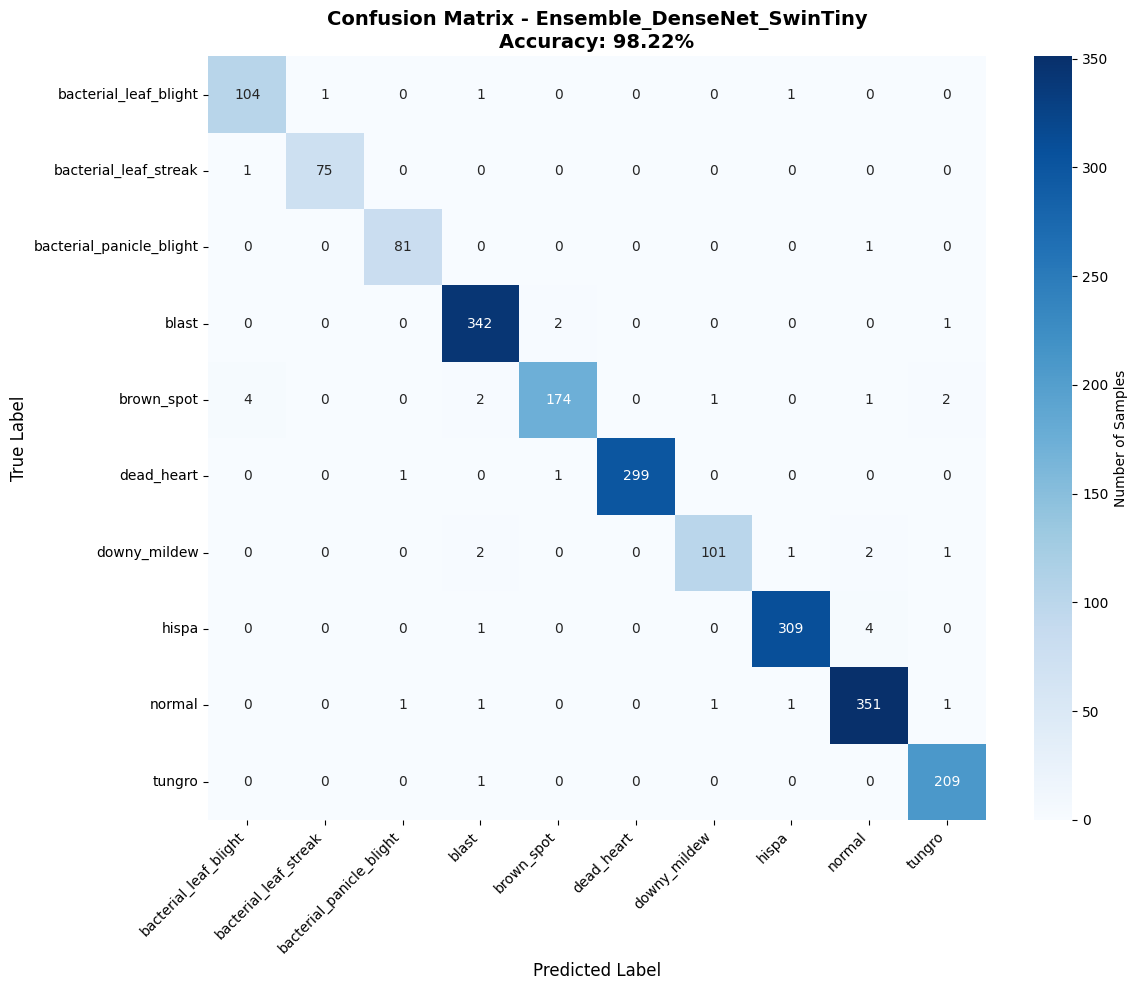

✓ Confusion matrix saved: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/logs/detection_results/visualizations/confusion_matrix.png


<Figure size 1400x600 with 0 Axes>

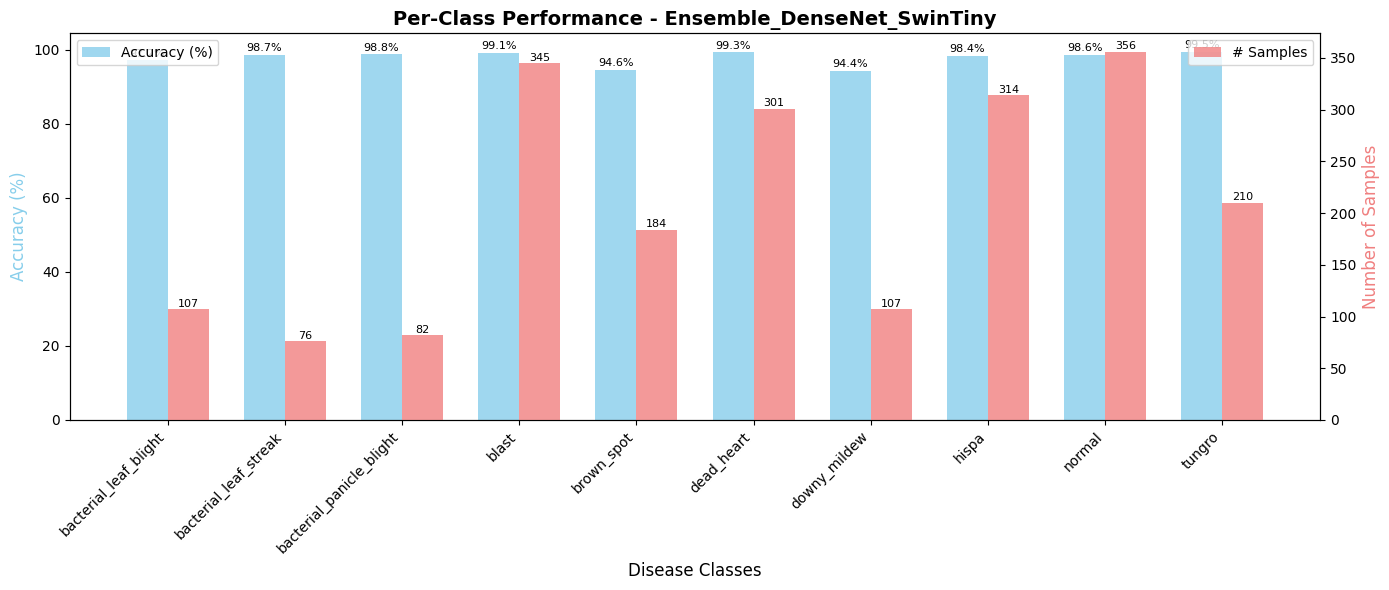

✓ Per-class performance chart saved: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/logs/detection_results/visualizations/per_class_performance.png


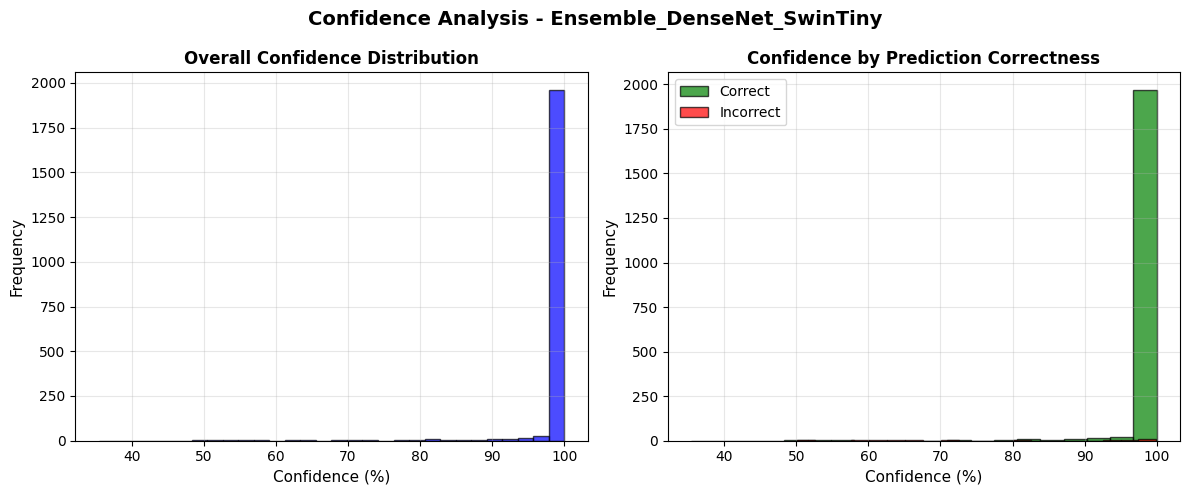

✓ Confidence analysis saved: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/logs/detection_results/visualizations/confidence_analysis.png


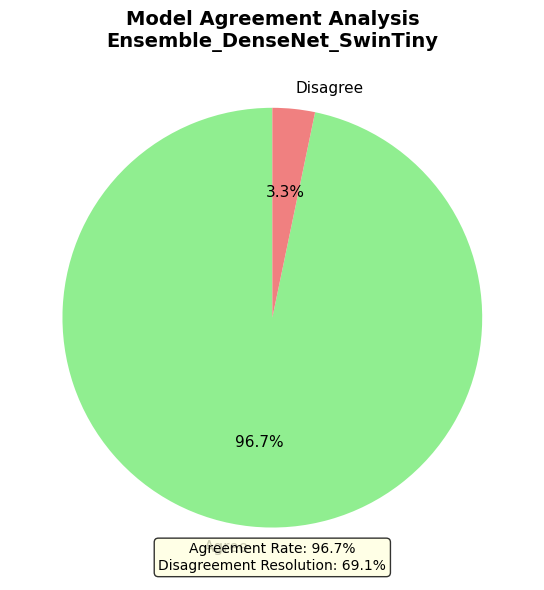

✓ Model agreement analysis saved: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/logs/detection_results/visualizations/model_agreement.png


In [ ]:
# ======================
# 5. VISUALIZE DETECTION RESULTS
# ======================

print("\n" + "="*50)
print("VISUALIZING DETECTION RESULTS")
print("="*50)

# Create visualization directory
VIS_DIR = os.path.join(DETECTION_DIR, "visualizations")
os.makedirs(VIS_DIR, exist_ok=True)

# 5.1 Confusion Matrix Heatmap
plt.figure(figsize=(12, 10))
cm = detection_metrics["confusion_matrix"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes,
            cbar_kws={'label': 'Number of Samples'})
plt.title(f'Confusion Matrix - {best_ensemble_name}\nAccuracy: {detection_metrics["overall_accuracy"]:.2f}%',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
confusion_path = os.path.join(VIS_DIR, "confusion_matrix.png")
plt.savefig(confusion_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Confusion matrix saved: {confusion_path}")

# 5.2 Per-Class Accuracy Bar Chart
plt.figure(figsize=(14, 6))
classes = list(detection_metrics["per_class_metrics"].keys())
accuracies = [detection_metrics["per_class_metrics"][c]["accuracy"] for c in classes]
samples = [detection_metrics["per_class_metrics"][c]["total_samples"] for c in classes]

x = np.arange(len(classes))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14, 6))
ax2 = ax1.twinx()

bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy (%)', color='skyblue', alpha=0.8)
bars2 = ax2.bar(x + width/2, samples, width, label='# Samples', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Disease Classes', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12, color='skyblue')
ax2.set_ylabel('Number of Samples', fontsize=12, color='lightcoral')
ax1.set_xticks(x)
ax1.set_xticklabels(classes, rotation=45, ha='right')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom', fontsize=8)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title(f'Per-Class Performance - {best_ensemble_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
per_class_path = os.path.join(VIS_DIR, "per_class_performance.png")
plt.savefig(per_class_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Per-class performance chart saved: {per_class_path}")

# 5.3 Confidence Distribution
plt.figure(figsize=(12, 5))

# Subplot 1: Overall confidence distribution
plt.subplot(1, 2, 1)
plt.hist(detection_results["confidences"] * 100, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Confidence (%)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Overall Confidence Distribution', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

# Subplot 2: Confidence by correctness
plt.subplot(1, 2, 2)
correct_mask = detection_results["predictions"] == detection_results["true_labels"]
plt.hist(detection_results["confidences"][correct_mask] * 100, bins=20, alpha=0.7,
         label='Correct', color='green', edgecolor='black')
plt.hist(detection_results["confidences"][~correct_mask] * 100, bins=20, alpha=0.7,
         label='Incorrect', color='red', edgecolor='black')
plt.xlabel('Confidence (%)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Confidence by Prediction Correctness', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.suptitle(f'Confidence Analysis - {best_ensemble_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
confidence_path = os.path.join(VIS_DIR, "confidence_analysis.png")
plt.savefig(confidence_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Confidence analysis saved: {confidence_path}")

# 5.4 Model Agreement Analysis
plt.figure(figsize=(10, 6))

agreement_data = [d["agreement"] for d in detection_results["details"]]
agreement_counts = pd.Series(agreement_data).value_counts()

colors = ['lightgreen', 'lightcoral']
plt.pie(agreement_counts.values, labels=['Agree', 'Disagree'],
        autopct='%1.1f%%', colors=colors, startangle=90,
        textprops={'fontsize': 11})
plt.title(f'Model Agreement Analysis\n{best_ensemble_name}', fontsize=14, fontweight='bold')

# Add statistics text
stats_text = f"Agreement Rate: {detection_metrics['model_agreement_rate']:.1f}%\n"
stats_text += f"Disagreement Resolution: {detection_metrics['disagreement_resolution_rate']:.1f}%"
plt.text(0, -1.2, stats_text, ha='center', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))

plt.tight_layout()
agreement_path = os.path.join(VIS_DIR, "model_agreement.png")
plt.savefig(agreement_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Model agreement analysis saved: {agreement_path}")

In [ ]:
# ======================
# 6. CREATE SAMPLE DETECTION VISUALIZATIONS
# ======================

print("\n" + "="*50)
print("CREATING SAMPLE DETECTION VISUALIZATIONS")
print("="*50)

def visualize_sample_detections(detection_results, dataset, num_samples=12):
    """Create visualizations of sample detections"""

    # Get indices for different scenarios
    correct_high_conf = []
    correct_low_conf = []
    incorrect_high_conf = []
    incorrect_low_conf = []

    for i, detail in enumerate(detection_results["details"]):
        if detail["is_correct"]:
            if detail["ensemble_confidence"] > 0.8:
                correct_high_conf.append(i)
            else:
                correct_low_conf.append(i)
        else:
            if detail["ensemble_confidence"] > 0.8:
                incorrect_high_conf.append(i)
            else:
                incorrect_low_conf.append(i)

    # Select samples from each category
    samples_per_category = num_samples // 4
    selected_indices = []

    for category in [correct_high_conf, correct_low_conf, incorrect_high_conf, incorrect_low_conf]:
        if len(category) > samples_per_category:
            selected = random.sample(category, samples_per_category)
        else:
            selected = category
        selected_indices.extend(selected)

    # Create visualization
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for idx, ax_idx in enumerate(selected_indices[:12]):
        detail = detection_results["details"][ax_idx]

        # Get the original image
        dataset_idx = detail["image_index"]
        if dataset_idx < len(val_dataset):
            # Get image from validation dataset
            image1, image2, label = val_dataset[dataset_idx]
            image = image2  # Use swin-sized image for display

            # Convert tensor to numpy for display
            img_np = image.permute(1, 2, 0).cpu().numpy()

            # Denormalize
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = std * img_np + mean
            img_np = np.clip(img_np, 0, 1)

            # Display image
            ax = axes[idx]
            ax.imshow(img_np)

            # Add prediction info
            status = "✓" if detail["is_correct"] else "✗"
            color = "green" if detail["is_correct"] else "red"

            title = f"{status} True: {detail['true_class']}\nPred: {detail['ensemble_predicted_class']}"
            title += f"\nConf: {detail['ensemble_confidence']*100:.1f}%"

            ax.set_title(title, fontsize=9, color=color, fontweight='bold')
            ax.axis('off')

    # Hide empty subplots
    for idx in range(len(selected_indices), len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f'Sample Detections - {best_ensemble_name}\n' +
                '✓ = Correct, ✗ = Incorrect',
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

    sample_path = os.path.join(VIS_DIR, "sample_detections.png")
    plt.savefig(sample_path, dpi=150, bbox_inches='tight')
    plt.show()

    return sample_path

# Create sample visualizations
print("Creating sample detection visualizations...")
sample_viz_path = visualize_sample_detections(detection_results, val_dataset, num_samples=12)
print(f"✓ Sample detection visualizations saved: {sample_viz_path}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ======================
# 7. CREATE DETAILED DETECTION REPORT
# ======================
import json
print("\n" + "="*50)
print("CREATING DETAILED DETECTION REPORT")
print("="*50)

def create_detection_report(detection_results, detection_metrics, best_ensemble_name, best_ensemble_acc):
    """Create comprehensive detection report"""

    report = {
        "report_info": {
            "generated_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
            "ensemble_name": best_ensemble_name,
            "ensemble_accuracy": float(best_ensemble_acc / 100)
        },
        "overall_metrics": {
            "accuracy": float(detection_metrics["overall_accuracy"]),
            "avg_confidence_correct": float(detection_metrics["avg_confidence_correct"]),
            "avg_confidence_incorrect": float(detection_metrics["avg_confidence_incorrect"]),
            "model_agreement_rate": float(detection_metrics["model_agreement_rate"]),
            "disagreement_resolution_rate": float(detection_metrics["disagreement_resolution_rate"])
        },
        "per_class_performance": detection_metrics["per_class_metrics"],
        "confusion_matrix": detection_metrics["confusion_matrix"],
        "classification_report": detection_metrics["classification_report"],
        "error_analysis": {
            "most_confident_errors": [],
            "least_confident_correct": [],
            "model_disagreements": []
        },
        "sample_predictions": []
    }

    # Error analysis: Most confident errors
    errors = [d for d in detection_results["details"] if not d["is_correct"]]
    errors_sorted = sorted(errors, key=lambda x: x["ensemble_confidence"], reverse=True)
    report["error_analysis"]["most_confident_errors"] = errors_sorted[:10]

    # Error analysis: Least confident correct predictions
    correct = [d for d in detection_results["details"] if d["is_correct"]]
    correct_sorted = sorted(correct, key=lambda x: x["ensemble_confidence"])
    report["error_analysis"]["least_confident_correct"] = correct_sorted[:10]

    # Error analysis: Model disagreements
    disagreements = [d for d in detection_results["details"] if not d["agreement"]]
    report["error_analysis"]["model_disagreements"] = disagreements[:20]

    # Sample predictions for report
    sample_indices = random.sample(range(len(detection_results["details"])), min(50, len(detection_results["details"])))
    for idx in sample_indices:
        detail = detection_results["details"][idx]
        sample = {
            "image_index": detail["image_index"],
            "true_class": detail["true_class"],
            "predicted_class": detail["ensemble_predicted_class"],
            "confidence": detail["ensemble_confidence"],
            "is_correct": detail["is_correct"],
            "model1_prediction": full_dataset.classes[detail["model1_prediction"]],
            "model1_confidence": detail["model1_confidence"],
            "model2_prediction": full_dataset.classes[detail["model2_prediction"]],
            "model2_confidence": detail["model2_confidence"],
            "models_agree": detail["agreement"]
        }
        report["sample_predictions"].append(sample)

    return report

# Create the report
detection_report = create_detection_report(detection_results, detection_metrics, best_ensemble_name, best_ensemble_acc)

# Save the report
report_path = os.path.join(DETECTION_DIR, f"detection_report_{best_ensemble_name}.json")
with open(report_path, 'w') as f:
    json.dump(detection_report, f, indent=4)

print(f"✓ Detailed detection report saved: {report_path}")


CREATING DETAILED DETECTION REPORT
✓ Detailed detection report saved: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/logs/detection_results/detection_report_Ensemble_DenseNet_SwinTiny.json



🧪 TESTING WITH MULTIPLE IMAGES
Found 3 test images:
  • /content/drive/MyDrive/TestingbyZMA/paddy-disease-classification/train/tungro/100183.jpg
  • /content/drive/MyDrive/TestingbyZMA/paddy-disease-classification/train/bacterial_leaf_streak/101915.jpg
  • /content/drive/MyDrive/TestingbyZMA/paddy-disease-classification/train/hispa/104304.jpg
🧪 TESTING MULTIPLE IMAGES
Loading trained models for visualization...
Found DenseNet weights at: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/models/densenet121_fast_best.pth
✓ Grad-CAM hooks registered for DenseNet
✓ DenseNet121 loaded successfully
Found Swin-Tiny weights at: /content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/models/swin_tiny_fast_best.pth
✓ Swin-Tiny loaded successfully
✅ All available models loaded successfully!

[1/3] Processing: 100183.jpg
Error saving image: cannot write mode RGBA as JPEG
   ✅ Prediction: tungro (99.5%)

[2/3] Processing: 101915.jpg
Error saving image: cannot write mode RGBA as JPEG
   ✅ P

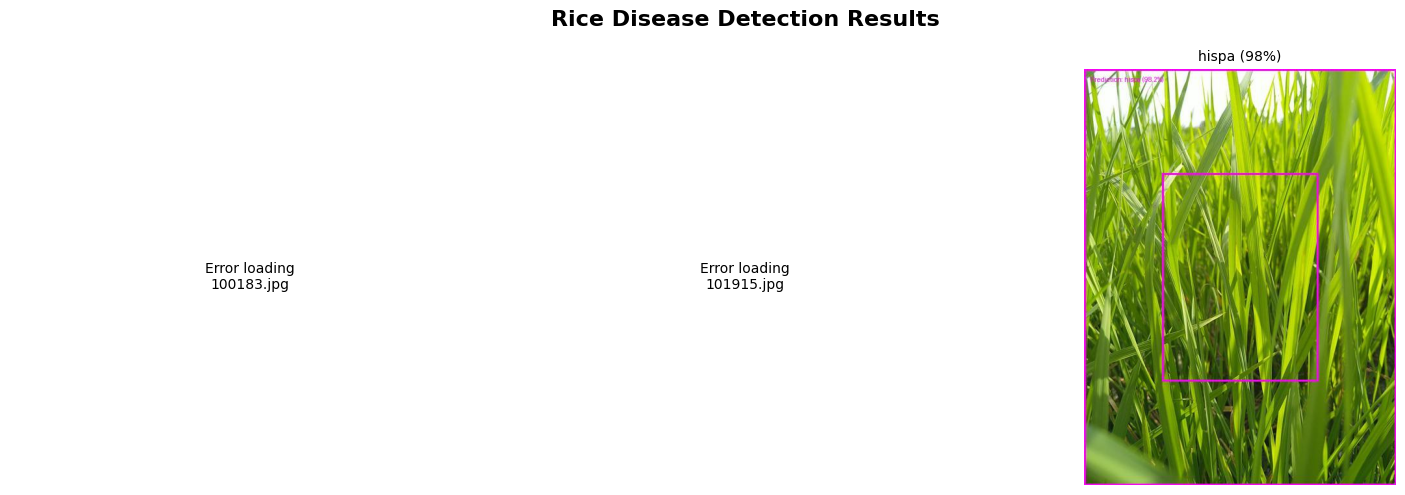


🎉 MULTIPLE IMAGE TEST COMPLETE!


In [21]:
def test_multiple_images(image_paths):
    """
    Test multiple images and create a summary report.

    Args:
        image_paths: List of image paths to test
    """
    print("=" * 70)
    print("🧪 TESTING MULTIPLE IMAGES")
    print("=" * 70)

    # Initialize detector
    MODEL_DIR = "/content/drive/MyDrive/TestingbyZMA/Rice_Models_Ensemble/models"
    detector = RiceDiseaseDetectorWithBBox(model_dir=MODEL_DIR)

    # Create output directory
    output_dir = "/content/drive/MyDrive/TestingbyZMA/Detection_Results"
    os.makedirs(output_dir, exist_ok=True)

    results = []

    for i, img_path in enumerate(image_paths):
        print(f"\n[{i+1}/{len(image_paths)}] Processing: {os.path.basename(img_path)}")

        if not os.path.exists(img_path):
            print(f"   ❌ Image not found, skipping...")
            continue

        try:
            # Make prediction
            predicted_class, confidence, all_confidences = detector.predict(
                img_path, return_confidence=True
            )

            # Create visualization
            filename = os.path.basename(img_path)
            save_path = os.path.join(output_dir, f"result_{filename}")

            annotated_img = detector.draw_detection_result(
                img_path, predicted_class, confidence,
                save_path=save_path,
                show_heatmap=True,
                show_info=False
            )

            # Store result
            results.append({
                'image': filename,
                'path': img_path,
                'prediction': predicted_class,
                'confidence': confidence,
                'result_path': save_path
            })

            print(f"   ✅ Prediction: {predicted_class} ({confidence:.1%})")

        except Exception as e:
            print(f"   ❌ Error: {e}")
            results.append({
                'image': os.path.basename(img_path),
                'path': img_path,
                'prediction': 'ERROR',
                'confidence': 0,
                'error': str(e)
            })

    # Create summary
    print("\n" + "="*70)
    print("📊 TEST SUMMARY")
    print("="*70)

    if results:
        print(f"\nProcessed {len([r for r in results if r.get('prediction') != 'ERROR'])}/{len(image_paths)} images successfully")

        # Show predictions
        print("\nPredictions:")
        for r in results:
            if r.get('prediction') != 'ERROR':
                print(f"  📸 {r['image']:30s} -> {r['prediction']:25s} ({r['confidence']:.1%})")
            else:
                print(f"  ❌ {r['image']:30s} -> ERROR: {r.get('error', 'Unknown error')}")

        # Find most common prediction
        if len(results) > 0:
            predictions = [r['prediction'] for r in results if r.get('prediction') != 'ERROR']
            if predictions:
                from collections import Counter
                most_common = Counter(predictions).most_common(1)[0]
                print(f"\n🏆 Most common disease: {most_common[0]} ({most_common[1]} images)")

        print(f"\n💾 All results saved to: {output_dir}")

        # Create a grid of results
        print("\n🖼️ Creating results grid...")

        # Filter successful results
        successful_results = [r for r in results if r.get('prediction') != 'ERROR']

        if successful_results:
            # Create a grid of images
            n_cols = min(3, len(successful_results))
            n_rows = (len(successful_results) + n_cols - 1) // n_cols

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

            if n_rows == 1 and n_cols == 1:
                axes = np.array([[axes]])
            elif n_rows == 1:
                axes = axes.reshape(1, -1)
            elif n_cols == 1:
                axes = axes.reshape(-1, 1)

            for idx, (ax, result) in enumerate(zip(axes.flat, successful_results)):
                try:
                    # Load annotated image
                    img = Image.open(result['result_path'])
                    ax.imshow(img)

                    # Add title
                    title = f"{result['prediction']} ({result['confidence']:.0%})"
                    ax.set_title(title, fontsize=10)
                    ax.axis('off')

                except Exception as e:
                    ax.text(0.5, 0.5, f"Error loading\n{result['image']}",
                           horizontalalignment='center', verticalalignment='center',
                           transform=ax.transAxes)
                    ax.axis('off')

            # Hide empty subplots
            for idx in range(len(successful_results), n_rows * n_cols):
                axes.flat[idx].axis('off')

            plt.suptitle('Rice Disease Detection Results', fontsize=16, fontweight='bold')
            plt.tight_layout()

            # Save grid
            grid_path = os.path.join(output_dir, "results_grid.png")
            plt.savefig(grid_path, dpi=150, bbox_inches='tight')
            print(f"📋 Results grid saved to: {grid_path}")

            plt.show()

    print("\n" + "="*70)
    print("🎉 MULTIPLE IMAGE TEST COMPLETE!")
    print("="*70)

    return detector, results

# Example: Test with a few images from different classes
def find_test_images(n=3):
    """Find n test images from different disease classes"""
    TRAIN_DIR = "/content/drive/MyDrive/TestingbyZMA/paddy-disease-classification/train"

    test_images = []

    if os.path.exists(TRAIN_DIR):
        disease_classes = [d for d in os.listdir(TRAIN_DIR)
                          if os.path.isdir(os.path.join(TRAIN_DIR, d))]

        # Take up to n classes
        for disease_class in disease_classes[:min(n, len(disease_classes))]:
            class_dir = os.path.join(TRAIN_DIR, disease_class)
            images = [f for f in os.listdir(class_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            if images:
                # Take first image from each class
                test_images.append(os.path.join(class_dir, images[0]))

    return test_images

# Run multiple image test
print("\n" + "="*70)
print("🧪 TESTING WITH MULTIPLE IMAGES")
print("="*70)

test_images = find_test_images(3)
if test_images:
    print(f"Found {len(test_images)} test images:")
    for img in test_images:
        print(f"  • {img}")

    detector, results = test_multiple_images(test_images)
else:
    print("❌ Could not find test images!")

zmma